# **Project Simulation**

In [113]:
# @title

! pip install simpy

import sys
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import math
import pandas as pd
import simpy
import queue

simulationDuration = 10000000

periodPrintLatency = 100
df_lossRates = pd.DataFrame(columns=['sourceID', 'time', 'lossRate'])
df_responseTime = pd.DataFrame(columns = ['sourceID', 'time', 'responseTime'])
df_nbSendPkt = pd.DataFrame(columns=['sourceID', 'time', 'culPacket'])
df_nbRcvPkt = pd.DataFrame(columns=['sourceID', 'time', 'culPacket'])
df_nbServicePkt = pd.DataFrame(columns=['sourceID', 'time', 'culPacket'])
df_avgMeanAndMeanSquare = pd.DataFrame(columns=["sourceID", "mean", "meanSquare", "sigma", "time"])

seqnum = 0
confidence = 0.95

isPrint = False

np.random.seed(10)

'''
def printLossRate(env, source):
  global df_lossRates
  source.cpterPrintLR += 1
  if source.cpterPrintLR == periodPrintLatency:
    source.cpterPrintLR = 0
    #print("loss[%s][%d]rate:%f" %(env.now, source.identity, source.queueLoss/source.nbEmissions))
    df_lossRates.loc[len(df_lossRates)] = {'sourceID':source.identity ,'time':env.now, 'lossRate': source.queueLoss/source.nbEmissions}
'''
def printLatency(env, source, estimator):
  global df_lossRates
  source.cpterPrintLatency += 1
  if source.cpterPrintLatency == periodPrintLatency:
    source.cpterPrintLatency = 0
    #print("loss[%s][%d]rate:%f" %(env.now, source.identity, source.queueLoss/source.nbEmissions))
    df_responseTime.loc[len(df_responseTime)] = {'sourceID':source.identity ,'time':env.now, 'responseTime': source.cumulLatency/source.nbEmissions}
    estimator.checkStop(source)
    

class packet(object):
  def __init__(self, t, identity, pktSize, sendTime, source):
    global seqnum
    seqnum += 1
    self.t = t
    self.identity = identity
    self.pktSize = pktSize #bits
    self.seqnum = seqnum
    self.sendTime = sendTime #unit: set by user (timeUnit)
    self.source = source

class queueClass(object):
  def __init__(self, env, serviceRate, timeUnit, estimator):
    self.env = env
    self.inService = 0
    self.buffer = queue.Queue()
    self.queueLength = 0 #store in the queue
    self.serviceRate  = serviceRate#bps
    self.timeUnit = timeUnit
    self.lastChange = 0
    self.cpterPrintLatency = 0
    self.df_responseTime = pd.DataFrame(columns=['sourceID', 'time', 'responseTime'])
    self.estimator = estimator
    self.registerID = []
    self.srcStopTab = []

  def service(self):#DataLengt
    global isPrint
    p = self.buffer.get()
    source = p.source
    self.queueLength -= p.pktSize
    serviceDuration = p.pktSize/self.serviceRate/self.timeUnit
    if isPrint:
      print("service Duration:%lf" %(serviceDuration))
    df_nbServicePkt.loc[len(df_nbServicePkt)] = {'sourceID':p.identity ,'time':env.now, 'culPacket': p.seqnum}
    yield self.env.timeout(serviceDuration)
    Latency = self.env.now - p.sendTime
    if isPrint:
      print("Source[%d]Packet[%d]Latency = %f unit(%d)s" %(p.identity, p.seqnum, Latency, self.timeUnit))
    p.source.cumulLatency += Latency
    p.source.cumulLatencySquare += Latency**2
    printLatency(self.env, p.source, self.estimator)
    del p
    
    if self.isStop(source):
      end_event = self.env.event()
      end_event.succeed()
      print("Stop")
      return "Stop"
    elif self.queueLength > 0:
      self.env.process(self.service())
    else:
      self.inService = 0
      #record loss count
  def isStop(self,source):
    global simulationDuration
    if self.env.now > simulationDuration:
      return True
    for i in range(0,len(self.srcStopTab)):
      if source.ableToStop and source.identity == self.registerID[i] and self.srcStopTab[i] == False:
        self.srcStopTab[i] = True
        print("Source %d Stop" %(source.identity))
      if self.srcStopTab[i] == False:
        return False
    return True

  def reception(self, source, pkt):
    source.nbEmissions += 1
    df_nbRcvPkt.loc[len(df_nbRcvPkt)] = {'sourceID':source.identity ,'time':env.now, 'culPacket': pkt.seqnum}

    self.queueLength += pkt.pktSize
    self.buffer.put(pkt)
    if self.inService == 0:
      self.inService = 1
      self.env.process(self.service())

class poissonSource(object):
  def __init__(self, env, dataRate, timeUnit, q, ident, pktSize, pktProbability):#pktSize: bytes
    self.SourceType = 0
    self.env = env
    self.dataRate = dataRate #bps
    self.timeUnit = timeUnit
    self.queue = q
    self.identity = ident
    q.registerID.append(ident)
    q.srcStopTab.append(False)
    q.estimator.LastRecord.loc[len(q.estimator.LastRecord)] = {"sourceID":self.identity ,"LastMean":0, "CumulMean":0, "CumulMeanSquare":0, "time":0, "nData":0}
    self.pktSize = pktSize*8 #transform to bits
    self.pktProbability = pktProbability
    self.expPktSize = np.inner(self.pktProbability, self.pktSize)
    self.rate = self.dataRate / self.expPktSize
    self.nbEmissions = 0
    self.queueLoss = 0
    self.cpterPrintLatency = 0
    self.action = env.process(self.run())
    self.cumulLatency = 0
    self.cumulLatencySquare = 0
    self.ableToStop = False
  def getPktSize(self):
    randomNum = np.random.uniform(0,1,1)
    i = 0
    cdf = 0
    for pktProb in self.pktProbability:
      cdf += pktProb
      if randomNum < cdf:
        break
      i += 1
    return self.pktSize[i]

  def run(self):
    while True:
      nextPktDuration = np.random.poisson(lam=1/self.rate/self.timeUnit, size=None)
      #df_nbSendPkt.loc[len(df_nbSendPkt)] = {'sourceID':self.identity ,'time':env.now, 'culPacket': self.nbEmissions}
      yield self.env.timeout(nextPktDuration)

      # Generate Packet Size here
      pktSize = self.getPktSize()
      p = packet(self.env.now, self.identity, pktSize, self.env.now, self)
      if isPrint:
        print("Send Packet[%d] %d bits at time %s to Queue" %(p.identity, p.pktSize, self.env.now))

      self.queue.reception(self, p)
      #self.env.process(self.queue.reception(self, p))
      #printLossRate(self.env, self)

class videoSource(object):
  def __init__(self, env, Datarate, pktSize, timeUnit, q,ident, T_on, b):
    self.SourceType = 1
    self.env = env
    self.avgDataRate = Datarate #bps ==> average bytes/s
    self.timeUnit = timeUnit
    self.queue = q
    self.identity = ident
    q.registerID.append(ident)
    q.srcStopTab.append(False)
    q.estimator.LastRecord.loc[len(q.estimator.LastRecord)] = {"sourceID":self.identity ,"LastMean":0, "CumulMean":0, "CumulMeanSquare":0, "time":0, "nData":0}
    self.T_on = T_on
    self.b = b #bustiness
    self.constPeakDataRate = self.b * self.avgDataRate
    self.T_off = (self.b - 1)*T_on
    self.pktSize = pktSize * 8 #byes to bits
    self.nbEmissions = 0
    self.queueLoss = 0
    self.cpterPrintLatency = 0
    self.action = env.process(self.run())
    self.cumulLatency = 0
    self.cumulLatencySquare = 0
    self.ableToStop = False
  def run(self):
    global isPrint
    while True:

      SendDuration = np.random.exponential(scale=self.T_on, size=None)/self.timeUnit
      endTime = self.env.now + SendDuration
      while self.env.now < endTime:

        p = packet(self.env.now, self.identity, self.pktSize, self.env.now,self)
        self.queue.reception(self, p)
        if isPrint:
          print("Send Packet[%d] at time %s to Queue" %(p.identity, self.env.now))
        df_nbSendPkt.loc[len(df_nbSendPkt)] = {'sourceID':self.identity ,'time':self.env.now, 'culPacket': self.nbEmissions}
        yield self.env.timeout(self.pktSize/(self.constPeakDataRate)/self.timeUnit)

      offPktDuration = np.random.exponential(scale=self.T_off, size=None) / self.timeUnit
      if isPrint:
        print("Off Duration:%f, On Duration:%f per %e s" %(offPktDuration, SendDuration, self.timeUnit))
      yield self.env.timeout(offPktDuration)

      #self.env.process(self.queue.reception(self, p))
      #printLossRate(self.env, self)
#
class voiceSource(object):
  def __init__(self, env, dataRate, timeUnit, q, ident, packetSize): #packetSize: bytes
    self.SourceType = 2
    self.env = env
    self.packetSize = packetSize * 8 #bits
    self.dataRate = dataRate
    self.Interval = self.packetSize / self.dataRate #seconds
    self.timeUnit = timeUnit
    self.queue = q
    self.identity = ident
    q.registerID.append(ident)
    q.srcStopTab.append(False)
    q.estimator.LastRecord.loc[len(q.estimator.LastRecord)] = {"sourceID":self.identity ,"LastMean":0.0, "CumulMean":0.0,"CumulMeanSquare":0.0,"time":0.0, "nData":0.0}
    self.nbEmissions = 0
    self.queueLoss = 0
    self.cpterPrintLR = 0
    self.action = env.process(self.run())
    self.cumulLatency = 0
    self.cumulLatencySquare = 0
    self.cpterPrintLatency = 0
    self.ableToStop = False
  def run(self):
    global isPrint
    while True:
      nextPktDuration = self.Interval/self.timeUnit
      yield self.env.timeout(nextPktDuration)

      df_nbSendPkt.loc[len(df_nbSendPkt)] = {'sourceID':self.identity ,'time':env.now, 'culPacket': self.nbEmissions}

      p = packet(self.env.now, self.identity, self.packetSize, self.env.now, self)
      self.queue.reception(self, p)
      if isPrint:
        print("Send Packet[%d] at time %s to Queue" %(p.identity, self.env.now))


      #self.env.process(self.queue.reception(self, p))
      #printLossRate(self.env, self)
#

class Estimator(object):
  def __init__(self, cofidence, targetError):
    self.TotalLoss = 0
    self.TotalSend = 0
    self.LastPeriodLoss = 0
    self.LastPeriodSend = 0
    self.Z_T = 0 #Total Duration
    self.Z_t = [] #Every Z_t
    self.culmulVariance = 0
    self.sigma = []  #variance
    self.epsilon = [] #Error
    self.LastIndex = 0
    self.periodIndex = 0
    self.targetPrint = 0
    self.LastRecord = pd.DataFrame(columns=["sourceID","LastMean", "CumulMean", "CumulMeanSquare", "time", "nData"])
    self.LastRecord = self.LastRecord.astype(float)
   
    # P[X > err] < E[X^2]/error^2 < 1 - confidence
    # ==> sigma(variance) < sqrt(1 - confidence) * error
    self.coefficient = (1-confidence)**(1/2)
    self.targetErr = targetError
    #sigma < targetErr/
    
  def checkStop(self, source):
    currSigma = self.estimatedSigma(source)
    if currSigma < self.targetErr * self.coefficient:
      source.ableToStop = True
      

  def estimatedZ(self,source,NbLossLast, nbEmissionsLast):
    global df_lossRates
    if (source.nbEmissions - nbEmissionsLast) != 0 :
      self.Z_T = (source.queueLoss - NbLossLast) / (source.nbEmissions - nbEmissionsLast)
    self.Z_t.append(NbLossLast / nbEmissionsLast)
    self.periodIndex = len(self.Z_t)
    #self.LastIndex = len(df_lossRates)

  def estimatedSigma(self, source): #variance
    global df_avgMeanAndMeanSquare
    global isPrint
    # Sum( (LossRate(i) - MeanLossRate)^2 * DeltaPeriod ) / Period
    mean = source.cumulLatency/source.nbEmissions

    LastMean = self.LastRecord[self.LastRecord["sourceID"] == source.identity]["LastMean"]
    #"sourceID","LastMean", "CumulMean", "CumulMeanSquare", "time", "nData"
    LastMean = self.LastRecord.iloc[source.identity - 1, 1]
    self.LastRecord.iloc[source.identity - 1, 1] = mean
    
    sumOfMean = self.LastRecord.iloc[source.identity - 1, 2] + mean
    self.LastRecord.iloc[source.identity - 1, 2] = sumOfMean
    
    N = self.LastRecord.iloc[source.identity - 1, 5] + 1
    self.LastRecord.iloc[source.identity - 1, 5] = N
    
    sumOfMeanSquare = self.LastRecord.iloc[source.identity - 1, 3] + LastMean**2
    self.LastRecord.iloc[source.identity - 1, 3] = sumOfMeanSquare
    
    
    mean = sumOfMean/N
    meanSquare = sumOfMeanSquare/(N-1)
    sigma = (meanSquare - mean)**(1/2)
    
    #meanSquare = source.cumulLatencySquare/source.nbEmissions
  
    if isPrint:
      self.targetPrint += 1
      print("[%d]at %d packets mean:%e meanSquare:%f sigma:%f" %(source.identity, source.nbEmissions, mean, meanSquare, sigma))
    df_avgMeanAndMeanSquare.loc[len(df_avgMeanAndMeanSquare)] = {"sourceID":source.identity,"mean":mean, "meanSquare":meanSquare, "sigma": sigma,"time":source.env.now}
    
    return sigma


  def extimatedEpsilon(self):
    self.epsilon.append(self.sigma.append(coefficient*self.sigma(self.self.periodIndex)))




In [108]:
#q.estimator.LastRecord["sourceID"] == 1
a = q.estimator.LastRecord.index[q.estimator.LastRecord["sourceID"] == 1]
print(a)
b = q.estimator.LastRecord.iloc[0,1]
#print(q.estimator.LastRecord.iloc[a,])
print(b)
#q.estimator.LastRecord.iloc[a]["LastMean"] = 1
print(q.estimator.LastRecord.dtypes)

Index([0], dtype='int64')
107.48345225672793
sourceID             int64
LastMean           float64
CumulMean          float64
CumulMeanSquare    float64
time               float64
nData              float64
dtype: object


# **Main Function**

C:\Users\kevin\AppData\Local\Temp\ipykernel_12512\3094822289.py:320: RuntimeWarning: invalid value encountered in scalar divide
  meanSquare = sumOfMeanSquare/(N-1)
C:\Users\kevin\AppData\Local\Temp\ipykernel_12512\3094822289.py:320: RuntimeWarning: invalid value encountered in scalar divide
  meanSquare = sumOfMeanSquare/(N-1)
C:\Users\kevin\AppData\Local\Temp\ipykernel_12512\3094822289.py:320: RuntimeWarning: invalid value encountered in scalar divide
  meanSquare = sumOfMeanSquare/(N-1)


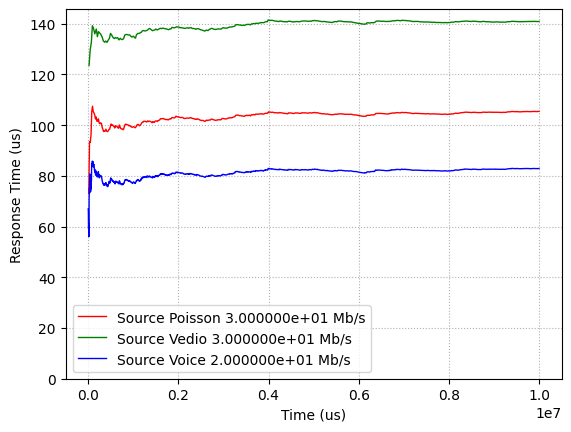

In [114]:
env = simpy.Environment()
end_event = env.event()
LatencyEstimator = Estimator(0.95, 100);
timeUnit = 10**(-6)
#queue setting
queueDataRate = 100*(10**6)
#source setting
poissonSrcRate = 30*(10**6)
poisoonSrcId = 1
poisoonSrcpktSize = np.array([50, 500, 1500])
poisoonSrcpktProb = np.array([0.4, 0.3, 0.3])

#vedio source setting
videoSrcAvgRate = 30 * (10**6)
videoSrcId = 2
videoT_on = 10**(-3)
#b = PeakRate(Constant=queue bit rate) / videoSrcRate(avg) = (T_on+T_off)/T_on
video_b = 1.5#(1,inf)]
videoPktSize= 1000

#voice data settig
voiceDatAvgRate = 20*(10**6)
voiceId = 3
voicePktSize = 100

q = queueClass(env, queueDataRate, timeUnit, LatencyEstimator)
ps1 = poissonSource(env, poissonSrcRate, timeUnit, q, poisoonSrcId, poisoonSrcpktSize, poisoonSrcpktProb)
ps2 = videoSource(env, videoSrcAvgRate, videoPktSize, timeUnit, q, videoSrcId, videoT_on, video_b)
ps3 = voiceSource(env, voiceDatAvgRate, timeUnit, q, voiceId, voicePktSize)

env.run(until=simulationDuration)

plt.plot(df_responseTime[df_responseTime['sourceID'] == 1]['time']\
    , df_responseTime[df_responseTime['sourceID'] == 1]['responseTime']\
    , linewidth = 1\
    , label = ('Source Poisson {SrcRate:e} Mb/s'.format(SrcRate = poissonSrcRate/(10**6)))
    , color = "r")

plt.plot(df_responseTime[df_responseTime['sourceID'] == 2]['time']\
    , df_responseTime[df_responseTime['sourceID'] == 2]['responseTime']\
    , linewidth = 1\
    , label = ('Source Vedio {SrcRate:e} Mb/s'.format(SrcRate = videoSrcAvgRate/(10**6)) )
    , color = "g")

plt.plot(df_responseTime[df_responseTime['sourceID'] == 3]['time']\
    , df_responseTime[df_responseTime['sourceID'] == 3]['responseTime']\
    , linewidth = 1\
    , label = ('Source Voice {SrcRate:e} Mb/s'.format(SrcRate = voiceDatAvgRate/(10**6)))
    , color = "b")

plt.grid(True, which = 'both', linestyle='dotted')
plt.ylim(ymin=0)
plt.ylabel('Response Time (us)')
plt.xlabel('Time (us)')
plt.legend()
#plt.savefig('myfig.pdf')

plt.show()
filename = ('b_{burstiness:.1f}_time_10e7'.format(burstiness = video_b))
compression_opts = dict(method='zip',
                        archive_name=(filename+'.csv'))  
df_responseTime.to_csv(filename+'.zip', index=False,
          compression=compression_opts) 

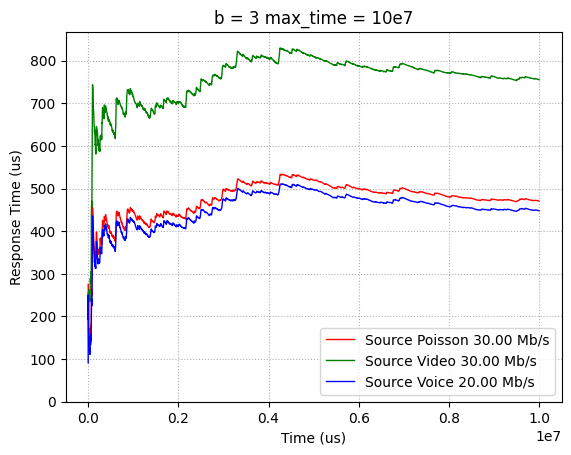

In [44]:
plt.plot(df_responseTime[df_responseTime['sourceID'] == 1]['time']\
    , df_responseTime[df_responseTime['sourceID'] == 1]['responseTime']\
    , linewidth = 1\
    , label = ('Source Poisson {SrcRate:.2f} Mb/s'.format(SrcRate = poissonSrcRate/(10**6)))
    , color = "r")

plt.plot(df_responseTime[df_responseTime['sourceID'] == 2]['time']\
    , df_responseTime[df_responseTime['sourceID'] == 2]['responseTime']\
    , linewidth = 1\
    , label = ('Source Video {SrcRate:.2f} Mb/s'.format(SrcRate = videoSrcAvgRate/(10**6)) )
    , color = "g")

plt.plot(df_responseTime[df_responseTime['sourceID'] == 3]['time']\
    , df_responseTime[df_responseTime['sourceID'] == 3]['responseTime']\
    , linewidth = 1\
    , label = ('Source Voice {SrcRate:.2f} Mb/s'.format(SrcRate = voiceDatAvgRate/(10**6)))
    , color = "b")

plt.grid(True, which = 'both', linestyle='dotted')
plt.ylim(ymin=0)
plt.ylabel('Response Time (us)')
plt.xlabel('Time (us)')
plt.legend()
plt.title("b = 3 max_time = 10e7")
#plt.savefig('myfig.pdf')


plt.show()

In [46]:
compression_opts = dict(method='zip',
                        archive_name='b_3_time_10e7.csv')  
df_responseTime.to_csv('b_3_time_10e7.zip', index=False,
          compression=compression_opts) 

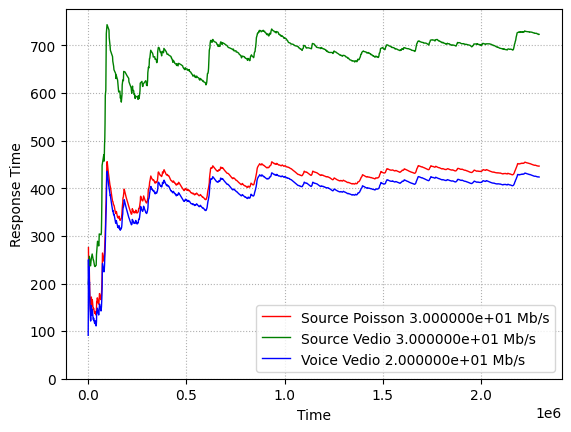

In [32]:
plt.plot(df_responseTime[df_responseTime['sourceID'] == 1]['time']\
    , df_responseTime[df_responseTime['sourceID'] == 1]['responseTime']\
    , linewidth = 1\
    , label = ('Source Poisson {SrcRate:e} Mb/s'.format(SrcRate = poissonSrcRate/(10**6)))
    , color = "r")

plt.plot(df_responseTime[df_responseTime['sourceID'] == 2]['time']\
    , df_responseTime[df_responseTime['sourceID'] == 2]['responseTime']\
    , linewidth = 1\
    , label = ('Source Vedio {SrcRate:e} Mb/s'.format(SrcRate = videoSrcAvgRate/(10**6)) )
    , color = "g")

plt.plot(df_responseTime[df_responseTime['sourceID'] == 3]['time']\
    , df_responseTime[df_responseTime['sourceID'] == 3]['responseTime']\
    , linewidth = 1\
    , label = ('Source Voice {SrcRate:e} Mb/s'.format(SrcRate = voiceDatAvgRate/(10**6)))
    , color = "b")

plt.grid(True, which = 'both', linestyle='dotted')
plt.ylim(ymin=0)
plt.ylabel('Response Time')
plt.xlabel('Time')
plt.legend()
#plt.savefig('myfig.pdf')
plt.show()

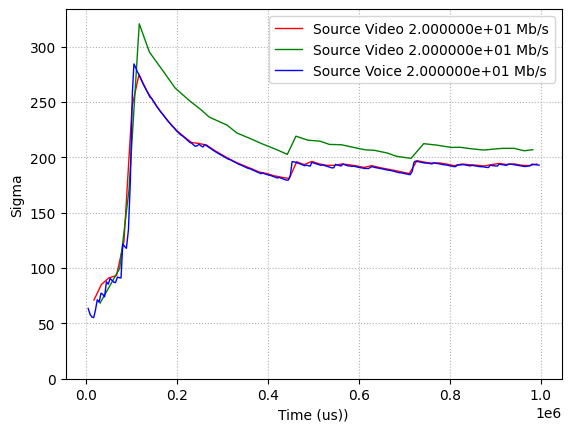

In [57]:
plt.plot(df_avgMeanAndMeanSquare[df_avgMeanAndMeanSquare['sourceID'] == 1]['time']\
    , ( df_avgMeanAndMeanSquare[df_avgMeanAndMeanSquare['sourceID'] == 1]['meanSquare'] - (df_avgMeanAndMeanSquare[df_avgMeanAndMeanSquare['sourceID'] == 1]['mean'])**2 )**(1/2)\
    , linewidth = 1\
    , label = ('Source Video {SrcRate:e} Mb/s'.format(SrcRate = voiceDatAvgRate/(10**6)))
    , color = "r")

plt.plot(df_avgMeanAndMeanSquare[df_avgMeanAndMeanSquare['sourceID'] == 2]['time']\
    , ( df_avgMeanAndMeanSquare[df_avgMeanAndMeanSquare['sourceID'] == 2]['meanSquare'] - (df_avgMeanAndMeanSquare[df_avgMeanAndMeanSquare['sourceID'] == 2]['mean'])**2 )**(1/2)\
    , linewidth = 1\
    , label = ('Source Video {SrcRate:e} Mb/s'.format(SrcRate = voiceDatAvgRate/(10**6)))
    , color = "g")

plt.plot(df_avgMeanAndMeanSquare[df_avgMeanAndMeanSquare['sourceID'] == 3]['time']\
    , ( df_avgMeanAndMeanSquare[df_avgMeanAndMeanSquare['sourceID'] == 3]['meanSquare'] - (df_avgMeanAndMeanSquare[df_avgMeanAndMeanSquare['sourceID'] == 3]['mean'])**2 )**(1/2)\
    , linewidth = 1\
    , label = ('Source Voice {SrcRate:e} Mb/s'.format(SrcRate = voiceDatAvgRate/(10**6)))
    , color = "b")

plt.grid(True, which = 'both', linestyle='dotted')
plt.ylim(ymin=0)
plt.ylabel('Sigma')
plt.xlabel('Time (us))')
plt.legend()
#plt.savefig('myfig.pdf')
plt.show()

In [ ]:
print(q.srcStopTab)
print(q.registerID)
for i in range(0, len(q.srcStopTab)):
    print(i)

In [31]:
df_avgMeanAndMeanSquare.head(7957)

,sourceID,mean,meanSquare,time
0,3,91.200000,16915.200000,604.0
1,2,200.000000,56340.839506,1200.0
2,3,134.666667,34496.000000,1208.0
3,3,215.500000,78874.000000,1612.0
4,3,250.000000,87233.043478,1852.0
...,...,...,...,...
7952,3,423.579993,519463.548967,2293439.0
7953,3,423.593341,519425.160497,2294159.0
7954,2,723.220118,913403.889353,2294463.0
7955,1,446.605657,538355.180884,2294795.0
